# LangGraph Crash Course

<img src="https://drive.google.com/uc?id=1bwlbmjbPZLXBizw5Ekl7icGgjiDM7RQP" alt="Alt text" width="700"/>


LangGraph is a framework designed for building **complex, stateful LLM agent and multi-agent applications**.

Unlike traditional linear workflows, LangGraph uses a **graph-based architecture** that gives developers fine-grained control over agent behaviorâ€”enabling features like conditional logic, tool prioritization, looping, and shared memory.

It's ideal for creating **robust, production-ready AI systems** that require precision and adaptability.

The first thing we need to do, is to install a bunch of **Python libraries** we'll need throughout this crash course.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community langgraph

# Understanding LangGraph Structure

Let's start by understanding the fundamental components of LangGraph and how to create a simple graph.


<img src="https://drive.google.com/uc?id=1HlCxqbbJ_xyIFCSimyPKAS_MVcGnne7J" alt="Alt text" width="700"/>


Remember that LangGraph is based on three fundamental components: **state**, **nodes**, and **edges**. Let's start with the state.

## 1. State

Start by defining the State of the graph.

This state schema acts as the input structure for all Nodes and Edges within the graph.

In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## 2. Nodes

**Nodes are simply Python functions.**

Each node takes the state as its first positional argument, based on the previously defined `TypedDict` schema.

Since the state includes a `graph_state` key, each node can access it using `state['graph_state']`.

> Each node returns an updated value for graph_state, and by default, this new value will overwrite the existing one in the state.

In [3]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" Welcome"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" to the DataHack Summit!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" to Bengaluru!"}


## 3. Edges

Edges define the connections between nodes in the graph.

* **Normal edges** are used when you always want to transition from one node to anotherâ€”for example, from `node_1` to `node_2`.

* **Conditional edges** allow for **dynamic routing** based on logic. These are implemented as functions that evaluate the current state and return the name of the next node to execute.

In [4]:
import random
from typing import Literal

def decide_node(state) -> Literal["node_2", "node_3"]:

    user_input = state['graph_state']

    if random.random() < 0.5:
        return "node_2"

    return "node_3"

## 4. Graph Construction

Now it's time to build the graph using the components we've defined.

We'll use the `StateGraph` class to create the graph structure.

First, initialize a `StateGraph` with the `State` schema we defined earlier.

> Then, add your nodes and connect them with edges.

Use the special `START` node to define the entry point of the graphâ€”this is where user input enters the system.

The `END` node marks the terminal point where the graph finishes execution.

Once all nodes and edges are added, compile the graph to validate its structure.

You can also visualize the resulting graph as a **Mermaid diagram** for a clearer view of the workflow.

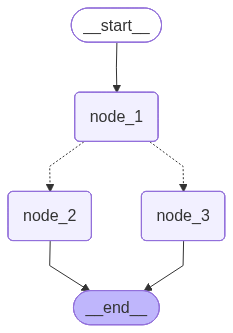

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)

# Defining the nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic - Defining the edges
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_node)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile the Graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## 5. Graph Execution

The compiled graph conforms to the `Runnable` protocol, which defines a standard interface for executing LangChain components.

One of the key methods in this interface is `.invoke()`.

You start by passing an input dictionary, such as `{"graph_state": "Hi there, it's Miguel!"}`, to set the initial value of the graph state.

When `.invoke()` is called, execution begins at the `START` node.

The graph then proceeds through the defined nodes (`node_1`, `node_2`, `node_3`), following the structure you built.

A conditional edge determines whether the flow goes from `node_1` to `node_2` or `node_3`, based on a 50/50 logic split.

Each node receives the current state, processes it, and returns an updated value, which replaces the previous graph_state.

Execution continues along the graph until the END node is reached, signaling completion.

In [6]:
graph.invoke({"graph_state" : "Hi there, it's Miguel!"})

---Node 1---
---Node 2---


{'graph_state': "Hi there, it's Miguel! Welcome to the DataHack Summit!"}

Congratulations, now we have an idea of how LangGraph works. Time to see what kind of LLM applications we can build with this framework!

# Building LLM Applications with LangGraph

Our **Telegram Agent** will follow a pattern known as the **Router**, in which the LLM decides which workflow to follow.

**This Router is an evolution of static LLM Chains.**

Let's take a look at how to implement each one in the following sections.

> Don't forget about the Levels of Autonomy in LLM Applications! ðŸ‘‡


<img src="https://drive.google.com/uc?id=1eQtFcYG3Elfdl0_jCGEgM7bUTiv-o213" alt="Alt text" width="700"/>


## Chains

<img src="https://drive.google.com/uc?id=1SKEFGB3PXL6UVCAYBXA7ZhW_Dobu3ht3" alt="Alt text" width="700"/>

Let's build a simple chain that combines 4 concepts:

* Using chat messages as our graph state
* Using chat models in graph nodes
* Binding tools to our chat model
* Executing tool calls in graph nodes

### 1. Messages

Chat models can handle different types of messages representing various roles in a conversation. LangChain supports key message types like:

* `HumanMessage` - from the user
* `AIMessage` - from the chat model
* `SystemMessage` - to guide the model's behavior
* `ToolMessage` - responses from tool calls

Let's build a list of messages. Each message can include:

* **content** - the message text
* **name** - optional author name
* **response_metadata** - optional metadata (e.g. from model providers for AIMessage, like OpenAI)


In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Hello, I'm your virtual travel assistant for Bengaluru. How can I help you plan your visit?", name="Agent")]
messages.append(HumanMessage(content="Hi, I'm visiting Bengaluru for the first time. Can you suggest key places to see?", name="Miguel"))
messages.append(AIMessage(content="Certainly. Some must-visit places include Lalbagh Botanical Garden, Bangalore Palace, and Cubbon Park. Are you interested in cultural sites, nature, or food experiences?", name="Agent"))
messages.append(HumanMessage(content="I'm interested in a mix of history and local cuisine.", name="Miguel"))
messages.append(AIMessage(content="Great choice. You can explore Tipu Sultan's Summer Palace for history, then head to VV Puram Food Street for authentic local dishes.", name="Agent"))

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Agent

Hello, I'm your virtual travel assistant for Bengaluru. How can I help you plan your visit?
================================ Human Message =================================
Name: Miguel

Hi, I'm visiting Bengaluru for the first time. Can you suggest key places to see?
================================== Ai Message ==================================
Name: Agent

Certainly. Some must-visit places include Lalbagh Botanical Garden, Bangalore Palace, and Cubbon Park. Are you interested in cultural sites, nature, or food experiences?
================================ Human Message =================================
Name: Miguel

I'm interested in a mix of history and local cuisine.
================================== Ai Message ==================================
Name: Agent

Great choice. You can explore Tipu Sultan's Summer Palace for history, then head to VV Puram Food Street for authentic local dishe

### Chat Models

Chat models accept a sequence of messages as input and support multiple message types, as previously mentioned.

Among the available options, we'll be working with **OpenAI**.

Before proceeding, we'll check if your `OPENAI_API_KEY` is configured. If it's not, you'll be prompted to provide it.

In [8]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [10]:
type(result)

langchain_core.messages.ai.AIMessage

In [11]:
result.pretty_print()

================================== Ai Message ==================================

Additionally, you might enjoy the Bangalore Fort for more historical insights. Afterward, try local delicacies like dosas and Vada pav at some of the iconic eateries around the city. Is there a specific type of cuisine or dish you'd like to try?


We can see the content by accessing the `content` property.

In [12]:
result.content

"Additionally, you might enjoy the Bangalore Fort for more historical insights. Afterward, try local delicacies like dosas and Vada pav at some of the iconic eateries around the city. Is there a specific type of cuisine or dish you'd like to try?"

### Tools



Tools are valuable when you need a model to interact with **external systems**.

These systems (such as APIs) typically expect **structured inputs** rather than natural language.

> By binding an API as a tool, you make the model aware of the expected input format.


The model decides when to call a tool based on the user's natural language input, and the output will follow the tool's defined schema.

Many LLM providers now support tool calling, and LangChain offers a straightforward interface for it.

You can bind any Python function using `ChatModel.bind_tools(function)`.




<img src="https://drive.google.com/uc?id=1rzCEThHO58tv9YPPEu0jwKaoy7DS7XAL" alt="Alt text" width="700"/>

Let's showcase a very simple example of tool calling. The `multiply` function is our tool.

In [13]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [14]:
no_tool_call = llm_with_tools.invoke(
    [HumanMessage(content="Hey! How are you?", name="Miguel")]
)

In [15]:
no_tool_call.pretty_print()

================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [16]:
no_tool_call.content

"Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [17]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content=f"What is 2 multiplied by 3", name="Miguel")]
)

We can see a tool call return.

>The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

In [18]:
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_MGr2zbliG2abeskEH7hJzw0S)
 Call ID: call_MGr2zbliG2abeskEH7hJzw0S
  Args:
    a: 2
    b: 3


In [19]:
tool_call.content

''

In [20]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_MGr2zbliG2abeskEH7hJzw0S',
  'type': 'tool_call'}]

### Defining the State

Unlike the example graph we saw earlier, in this case we need to use `messages` (the message history) within the state.

If we wanted to handle this manually, we'd need to create another `TypedDict` with a messages property.

In [21]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

Fortunately, LangGraph already provides a built-in state type for this: `MessagesState`.

The cool thing about this class is that it already incorporates a `reducer`. This reducer logic will take care of appending the new message to the message list.

> All of these operations will be perform by LangGraph under the hood

In [22]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

### Building the Graph

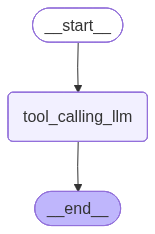

In [23]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We've implemented a very simple chain!

If we pass a general message (unrelated to math operations), the LLM will respond without any tool call.

In [24]:
messages = graph.invoke({"messages": HumanMessage(content="Hey there! I'm Miguel")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hey there! I'm Miguel
================================== Ai Message ==================================

Hello Miguel! How can I assist you today?


But, if we ask about a multiplication, the LLM will use our tool.

In [25]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 10 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 10 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TnnfppSMvtOCQas7kO09oUFB)
 Call ID: call_TnnfppSMvtOCQas7kO09oUFB
  Args:
    a: 10
    b: 3


---

## Router

You can think of this as a **router**, where the chat model decidesâ€”based on user inputâ€”whether to respond directly or to call a tool.

This represents a basic form of an agent, where the LLM manages control flow by choosing between tool invocation and generating a direct reply.

<img src="https://drive.google.com/uc?id=18D4oguG3jAxr9GoQJcHZUevxcEdudkHh" alt="Alt text" width="700"/>


Let's extend the Chain example (the tool calling chain) like this:

(1) Add a node that will call our tool

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed

In [26]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

 We use the built-in `ToolNode` and simply pass a list of our tools to initialize it.

 We use the built-in `tools_condition` as our conditional edge.

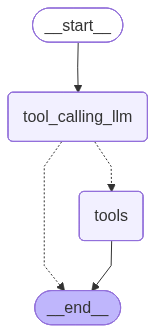

In [27]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oax2Y6snzRgk1q8RV3h9EMIa)
 Call ID: call_oax2Y6snzRgk1q8RV3h9EMIa
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


---

## ReAct Agent

<img src="https://drive.google.com/uc?id=1HSQUzZAkCv_Ec-1EES1yZZFCPKizISsW" alt="Alt text" width="700"/>

The ReAct pattern is one of the most common for agentic architectures. It's the one we'll be using for our Telegram Bot as well.

You can think of it as an evolution of the Router pattern.

In the router above, we invoked the model â€” and if it decided to call a tool, we returned a ToolMessage to the user.

But what if, instead, we passed that ToolMessage back to the model?


That way, it gets to decide what's next:

(1) **Call another tool**

(2) **Respond directly**

ReAct stands for "Reason + Act", and can be easily understood by the following diagram.

<img src="https://drive.google.com/uc?id=1BfpjPboaDU0fJ1dtuuBuVhjZxRlVDJB1" alt="Alt text" width="700"/>

To test how the ReAct architecture works, let's create three tools instead of one.

In [29]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

Now, let's bind the three tools to the OpenAI ChatModel.

In [30]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create a simple node for defining the assistant behaviour.

In [31]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic operations")


def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Finally, let's build and compile the graph.

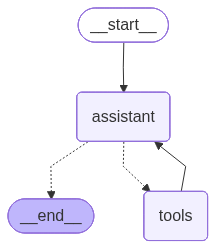

In [32]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

# IMPORTANT! -> Now the 'tools' node points back to the 'assistant' node, creating a loop
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Let's try it out ...

In [33]:
messages = [HumanMessage(content="Add 10 and 5. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [34]:
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Add 10 and 5. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_0EmsdVP8SqisXGAuk8AsXdb6)
 Call ID: call_0EmsdVP8SqisXGAuk8AsXdb6
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: add

15
================================== Ai Message ==================================
Tool Calls:
  multiply (call_qMd9Z7nlb468N3UZciUUr2we)
 Call ID: call_qMd9Z7nlb468N3UZciUUr2we
  Args:
    a: 15
    b: 2
================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================
Tool Calls:
  divide (call_DZfxzJOP1KyrVXzbBDCc9mPV)
 Call ID: call_DZfxzJOP1KyrVXzbBDCc9mPV
  Args:
    a: 30
    b: 5
================================= Tool Message ===========